# Introduction

Note: this section is no longer being used in the data pipeline.

This section is an attempt to homogenise the same ingredients which are written in different nomanclature. For such a large dataset coming from numermous sources, there will be many duplicate ingredients that just have slight differences in formatting/spelling/nomanclature. What we want to match these according to a similarity criteria, through a process called *fuzzy matching*.

The reason behind this was that it would help the manual process of checking/fixing ingredients, by greatly reducing the number of unique ingredients, hence reducing the possible issues that might have to be addressed.

However through the processing of this, it was decided that this would actually introduce more possibilities for error whilst not helping the overall process.

# Process

- Stage 1: Cleaning (already done in dataset preprocessing)
    - Casing
    - Lemmatization
    - Punctuation Cuts
- Stage 2: Similarity Matching
    - Levenstein Distance
    - Embedding Distance
- Stage 3: Manual Additon
    - Previous step should be done liberally, allowing for mistakes to be added back manually - or with LLM?

# Setup

In [ ]:
from pyprojroot import here
root = here()
import sys
sys.path.append(str(root))

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import nltk
import spacy
from spacy.matcher import Matcher
from spacy.util import filter_spans

from thefuzz import fuzz

from sentence_transformers import SentenceTransformer
from sentence_transformers.util import cos_sim
import torch
from sklearn.metrics.pairwise import cosine_similarity

import json
from itertools import groupby
import re
import string

from tqdm import tqdm
tqdm.pandas()

from food_database.utils.utils import *

In [2]:
ingredients_df = pd.read_feather('../data/local/recipe/partial/ingredients/0.feather')

# Similarity Matching

### Levenstein Distance

Here we want to calculate the distances of all the ingredients from eachother, using the levenstein distance. With this we'll be able to set a threshold of similarity for which we homogenise the ingredients.

In [3]:
ct = pd.crosstab(ingredients_df['name.name'].unique(), ingredients_df['name.name'].unique())
ct = ct.apply(lambda col: [fuzz.ratio(col.name, x) for x in col.index])

#### Threshold

With this all we want to do is be able to understand slight spelling mistakes. Starting with a lower limit here, changes in shorter words will have a greater effect. What does a one letter spelling difference score on a short word?

In [4]:
fuzz.ratio('chilli', 'chili')

91

In [5]:
similar_fuzzy = ct.apply(lambda x: list(x[x>90].index), axis=1).to_frame('similar_values')
similar_fuzzy['size'] = similar_fuzzy['similar_values'].apply(len)
similar_fuzzy = similar_fuzzy[similar_fuzzy['size'] > 1]
similar_fuzzy.sort_values('size', ascending=False).head(10)

,similar_values,size
row_0,,
bread crumb,"[bread crumb, breadcrumb]",2
breadcrumb,"[bread crumb, breadcrumb]",2
yoghurt,"[yoghurt, yogurt]",2
soymilk,"[soy milk, soymilk]",2
soy milk,"[soy milk, soymilk]",2
pimiento,"[pimento, pimiento]",2
pimento,"[pimento, pimiento]",2
ground turkey,"[grnd turkey, ground turkey]",2
grnd turkey,"[grnd turkey, ground turkey]",2


Which element of the list will we keep here? It looks like for a large part the list values orders do stay the same, as they are created in order of the rows that they appear. Let's map them and then after see how this is affected.

From having a play around with the boundary values here it looks like 90% match is about right. The main goal here is to get the obviously similar values, ones where the difference only comes down to plurals or slightly different spellings. What we want to avoid is putting together ingredients which are not the same eg. baby leaves & bay leaves. However if the plan is to manually check these after, it's better to be more liberal, as the values can be removed from the list.

In [6]:
fuzzy_map = similar_fuzzy['similar_values'].to_dict()
fuzzy_map = {k: v[0] for k, v in fuzzy_map.items()}
fuzzy_map.items()

dict_items([('bread crumb', 'bread crumb'), ('breadcrumb', 'bread crumb'), ('chick pea', 'chick pea'), ('chickpea', 'chick pea'), ('chili', 'chili'), ('chili powder', 'chili powder'), ('chili pwdr', 'chili powder'), ('chilli', 'chili'), ('cream', 'cream'), ('creamy', 'cream'), ('extra virgin olive oil', 'extra virgin olive oil'), ('extra-virgin olive oil', 'extra virgin olive oil'), ('fresh ground black pepper', 'fresh ground black pepper'), ('freshly ground black pepper', 'fresh ground black pepper'), ('green chile', 'green chile'), ('green chilies', 'green chile'), ('grnd turkey', 'grnd turkey'), ('ground turkey', 'grnd turkey'), ('pimento', 'pimento'), ('pimiento', 'pimento'), ('soy milk', 'soy milk'), ('soymilk', 'soy milk'), ('yoghurt', 'yoghurt'), ('yogurt', 'yoghurt')])

In [7]:
ingredients_df['name.name.mapped'] = ingredients_df['name.name'].replace(fuzzy_map)
ingredients_df['name.name.mapped'][ingredients_df['name.name.mapped'] == 'baking pwdr']

Series([], Name: name.name.mapped, dtype: object)

In [8]:
ingredients_df['name.name.mapped'].nunique()

732

In [9]:
ct = pd.crosstab(ingredients_df['name.name.mapped'].unique(), ingredients_df['name.name.mapped'].unique())
ct = ct.apply(lambda col: [fuzz.ratio(col.name, x) for x in col.index])

In [10]:
similar_fuzzy = ct.apply(lambda x: list(x[x>90].index), axis=1).to_frame('similar_values')
similar_fuzzy['size'] = similar_fuzzy['similar_values'].apply(len)
similar_fuzzy = similar_fuzzy[similar_fuzzy['size'] > 1]
similar_fuzzy.sort_values('size', ascending=False).head(20)

,similar_values,size
row_0,,


It looks like this needs to be done for a number of iterations to straighten them all out. This is because the mapping of an ingredient changes it slightly, which then has the possibility to meet a similarity threshold that it previously wouldn't have.

In [11]:
#todo choose map valu on most common appearance
# -> this would help the search also as the most common appearance is also the most likely to be in the other databases

In [12]:
def map_similar_values(similarity_matrix_func, similarity_threshold, values_series):
    values = values_series.unique()
    similarity_matrix = similarity_matrix_func(values)
    similarity_df = similarity_matrix.apply(lambda x: list(x[x>similarity_threshold].index), axis=1).to_frame('similar_values')
    similarity_df['size'] = similarity_df['similar_values'].apply(len)
    similarity_df = similarity_df[similarity_df['size'] > 1]
    similarity_map = similarity_df['similar_values'].to_dict()
    similarity_map = {k: sorted(v,key=len)[0] for k, v in similarity_map.items()}
    mapped_values_series = values_series.replace(similarity_map)
    return mapped_values_series, similarity_map

In [13]:
def create_fuzzy_similarity_matrix(values):
    similarity_matrix = pd.crosstab(values, values)
    similarity_matrix = similarity_matrix.apply(lambda col: [fuzz.ratio(col.name, x) for x in col.index])
    return similarity_matrix

In [14]:
ingredients_df['name.name.mapped'], similarity_map = map_similar_values(create_fuzzy_similarity_matrix, 90, ingredients_df['name.name'])
while similarity_map:
    ingredients_df['name.name.mapped'], similarity_map = map_similar_values(create_fuzzy_similarity_matrix, 90, ingredients_df['name.name.mapped'])
    print(similarity_map)

{}


In [15]:
ingredients_df['name.name.mapped'].nunique()

732

### Embedding Distance

In [16]:
if torch.cuda.is_available: torch_device = 'cuda'
elif torch.backends.mps.is_available(): torch_device = 'mps'
else: torch_device='cpu'

embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=torch_device)

embeddings = embedding_model.encode(ingredients_df['name.name.mapped'].unique())

<Axes: >

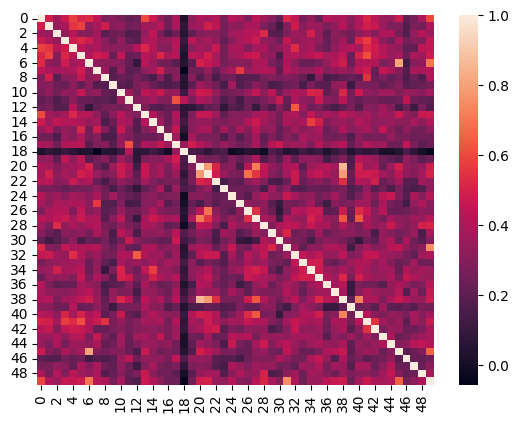

In [17]:


similarity_matrix = cosine_similarity(embeddings)
sns.heatmap(similarity_matrix[:50,:50])

In [18]:
similarity_matrix = pd.DataFrame(similarity_matrix)
similarity_matrix.columns = ingredients_df['name.name.mapped'].unique()
similarity_matrix.index = ingredients_df['name.name.mapped'].unique()

similarity_matrix.head()

,butter,sugar,egg,vanilla,flour,caramel,cream,pecan,semi-sweet chocolate chip,shortening,...,bean sprout,green cabbage,lemon basil,cauliflower,ra el hanout,cinnamin,raspberry,blackberry,ground thyme,jasmine rice
butter,1.000000,0.484835,0.358822,0.471172,0.582296,0.510937,0.522686,0.433225,0.281743,0.303705,...,0.233154,0.364364,0.354585,0.419292,0.107999,0.333893,0.205584,0.250776,0.190140,0.406707
sugar,0.484835,1.000000,0.344645,0.389489,0.554353,0.584906,0.326516,0.383169,0.484539,0.299603,...,0.271173,0.366384,0.251253,0.347484,0.091582,0.332875,0.327605,0.353409,0.177884,0.354725
egg,0.358822,0.344645,1.000000,0.336901,0.419621,0.306119,0.295463,0.369888,0.184887,0.239174,...,0.372799,0.388440,0.285718,0.325525,0.166071,0.269773,0.280815,0.276383,0.188414,0.237777
vanilla,0.471172,0.389489,0.336901,1.000000,0.472170,0.518156,0.475751,0.382221,0.316570,0.226089,...,0.277833,0.326218,0.425584,0.312265,0.147213,0.288658,0.398205,0.391526,0.276084,0.301913
flour,0.582296,0.554353,0.419621,0.472170,1.000000,0.431968,0.368110,0.405737,0.324982,0.315881,...,0.379072,0.425965,0.321945,0.386888,0.168914,0.328191,0.232829,0.194977,0.290617,0.418467


##### Threshold

It doesn't deal with spelling differences/mistakes, which is fine because that's what fuzzy searching is for.

In [19]:
cos_sim(*embedding_model.encode(['chilli powder', 'chilli pwdr']))

tensor([[0.6515]])

What we mainly want here is to be able to distinguish between synonyms.

In [20]:
cos_sim(*embedding_model.encode(['zucchini', 'courgette']))

tensor([[0.6377]])

In [21]:
cos_sim(*embedding_model.encode(['cornflour', 'cornstarch']))

tensor([[0.6450]])

-> This is a problem. It doesn't deal with common synonyms which is what we really need it to be doing.

In [22]:
cos_sim(*embedding_model.encode(['pork tenderloin', 'pork steak fillet']))

tensor([[0.7471]])

In [23]:
cos_sim(*embedding_model.encode(['salad', 'greens']))

tensor([[0.5140]])

We also don't want it reducing ingredients when specificity is required.

In [24]:
cos_sim(*embedding_model.encode(['white wine vinegar', 'balsamic vinegar']))

tensor([[0.8576]])

In [25]:
cos_sim(*embedding_model.encode(['cornstarch', 'cornflour']))

tensor([[0.6450]])

The issue with embeddings is that they are nto trained to be specific to ingredients, or even nouns in general. It might be a better idea to simply use a thesaurus for the words.

In [26]:
similar_values = similarity_matrix.apply(lambda x: list(x[x>0.9].index), axis=1).to_frame('similar_values')
similar_values['size'] = similar_values['similar_values'].apply(len).sort_values(ascending=False)
similar_values.sort_values('size', ascending=False).iloc[:20]

,similar_values,size
long grain rice,"[long grain brown rice, long grain white rice,...",3
long grain white rice,"[long grain brown rice, long grain white rice,...",3
instant chocolate pudding,"[instant chocolate pudding, instant vanilla pu...",3
red bell pepper,"[red pepper, bell pepper, red bell pepper]",3
long grain brown rice,"[long grain brown rice, long grain white rice,...",3
red wine vinegar,"[white wine vinegar, red wine vinegar]",2
dry mustard,"[dry mustard, dried mustard]",2
cake mix,"[cake mix, chocolate cake mix]",2
cranberry cocktail,"[cranberry cocktail, cranberry juice cocktail]",2
pasta sauce,"[spaghetti sauce, pasta sauce]",2


In [27]:
embedding_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=torch_device)

def create_embedding_similarity_matrix(values):
    embeddings = embedding_model.encode(values)
    similarity_matrix = cosine_similarity(embeddings)
    similarity_matrix = pd.DataFrame(similarity_matrix)
    similarity_matrix.columns = ingredients_df['name.name.mapped'].unique()
    similarity_matrix.index = ingredients_df['name.name.mapped'].unique()
    return similarity_matrix

In [28]:
similarity_map = {'exists': True}
while similarity_map:
    ingredients_df['name.name.mapped'], similarity_map = map_similar_values(create_embedding_similarity_matrix, 0.9, ingredients_df['name.name.mapped'])
    print(similarity_map)

{'long grain brown rice': 'long grain rice', 'oregano': 'oregano', 'cheddar cheese': 'cheddar', 'cream celery soup': 'celery soup', 'instant chocolate pudding': 'instant vanilla pudding', 'spaghetti sauce': 'pasta sauce', 'mozzarella': 'mozzarella', 'red pepper': 'red pepper', 'ground black pepper': 'ground black pepper', 'mozzarella cheese': 'mozzarella', 'green olive': 'green olive', 'fresh corn': 'fresh corn', 'white wine vinegar': 'red wine vinegar', 'brown sugar': 'brown sugar', 'black olive': 'green olive', 'cider vinegar': 'cider vinegar', 'bell pepper': 'bell pepper', 'dry mustard': 'dry mustard', 'fresh ground black pepper': 'ground black pepper', 'cranberry cocktail': 'cranberry cocktail', 'instant vanilla pudding': 'instant vanilla pudding', 'mustard seed': 'mustard seed', 'dried mustard': 'dry mustard', 'sweet paprika': 'sweet paprika', 'green pepper': 'green pepper', 'celery soup': 'celery soup', 'corn fresh': 'fresh corn', 'sweet smoked paprika': 'sweet paprika', 'fresh o

{'instant vanilla pudding': 'instant vanilla pudding', 'instant chocolate pudding': 'instant vanilla pudding'}
{}


In [29]:
ingredients_df['name.name.mapped'].nunique()

705

## Topic Conclusions

We've opted not to use this just now. The main use of this would be to ease manual changes - as reducing the number of unique ingredients would reduce the number of changes that would need to be made.